# Model Analysis
</p>In this notebook, we will analyze the performance of the models we have built. We will use the metrics `root_mean_squared_error`, `mean_absolute_error`, and `r2_score` to evaluate the performance of our models. We will also use the `bootstrap` and `kfold` functions to evaluate how well our models perform on unseen data.</p>

</p>For start, we will perform kfold cross-validation on the baseline models, which constitute of the 'ElasticNet', 'Bayesian Ridge' and 'Support Vector Regressor'. These will set the lower bound of our performance metrics.</p>

In [1]:
# Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib
import sys
import os
import optuna
# I had an issue with importing functions from the src directory, so I used chatGPT to get the line below
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import functions

</p>Before defining the models we will load the csv files for development and evaluation. Except for the rows that were removed during cleaning, we will also remove the Host age row since we showed that it does not provide meaningful information for the model.</p>

In [2]:
input_path = Path.cwd()
root = input_path.parent
data_path = root / "data" / "development_final_data.csv"
train_df = pd.read_csv(data_path, header=0)
x = train_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
y = train_df['BMI']
val_df = pd.read_csv(root / "data" / "evaluation_final_data.csv", header=0)
val_x = val_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
val_y = val_df['BMI']

</p>Below we use kfold cross-validation to evaluate the performance of the baseline models. We will use the `mean_absolute_error`, `root_mean_squared_error`, and `r2_score` functions from `sklearn.metrics` to evaluate the performance of our models. The procedure is run 20 times with 5 folds each time and the results are used to create boxplots for each metric</p>

Model: ElasticNet


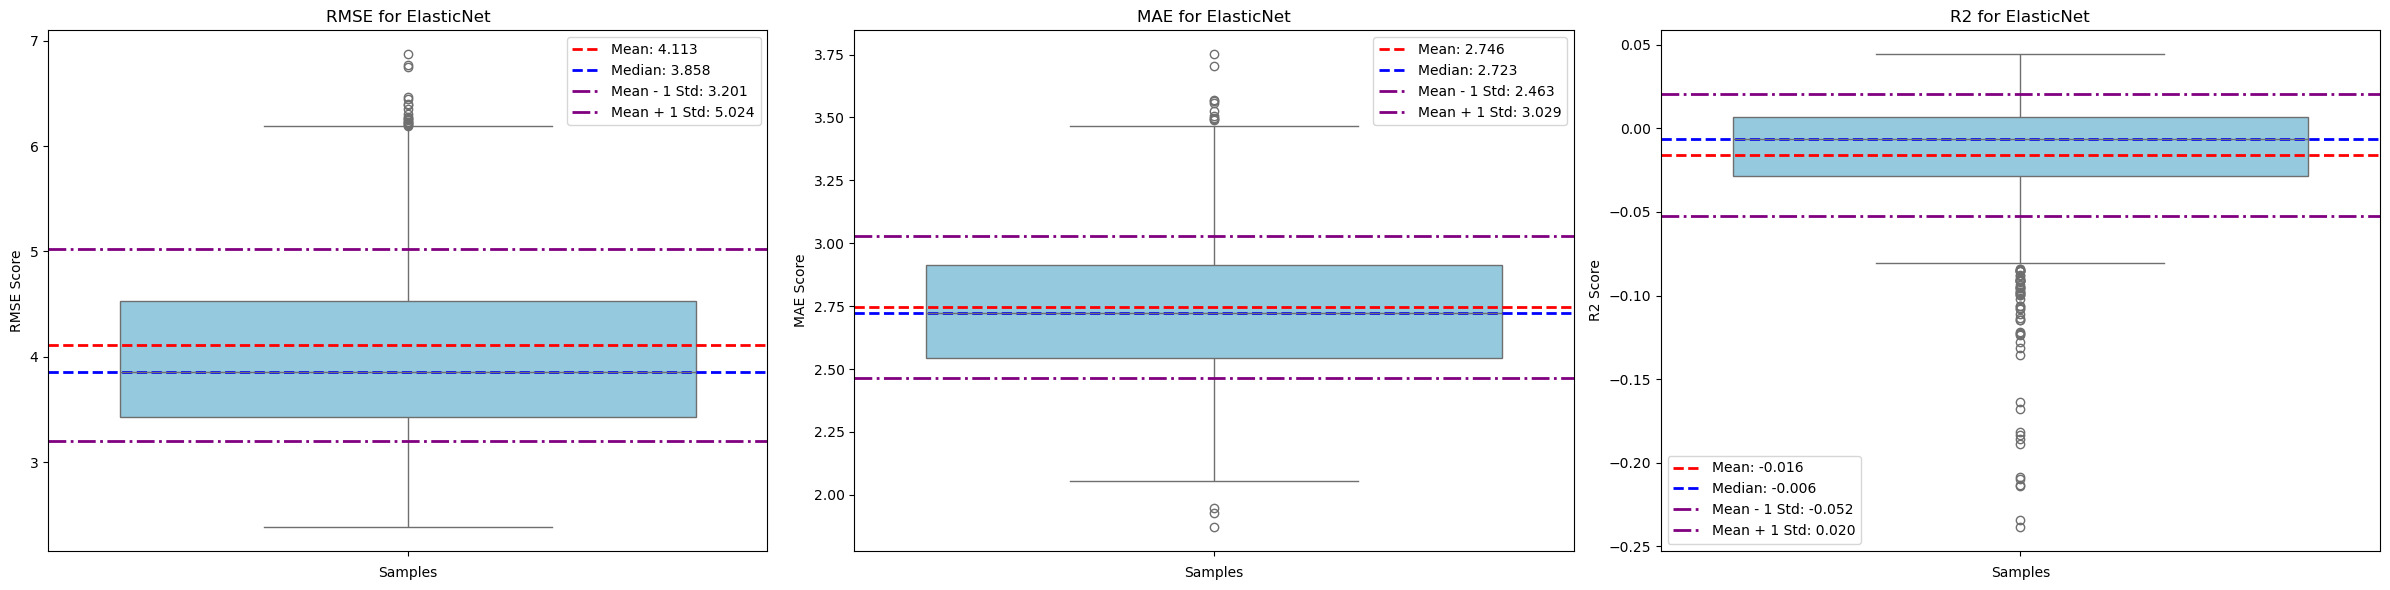

Model: BayesianRidge


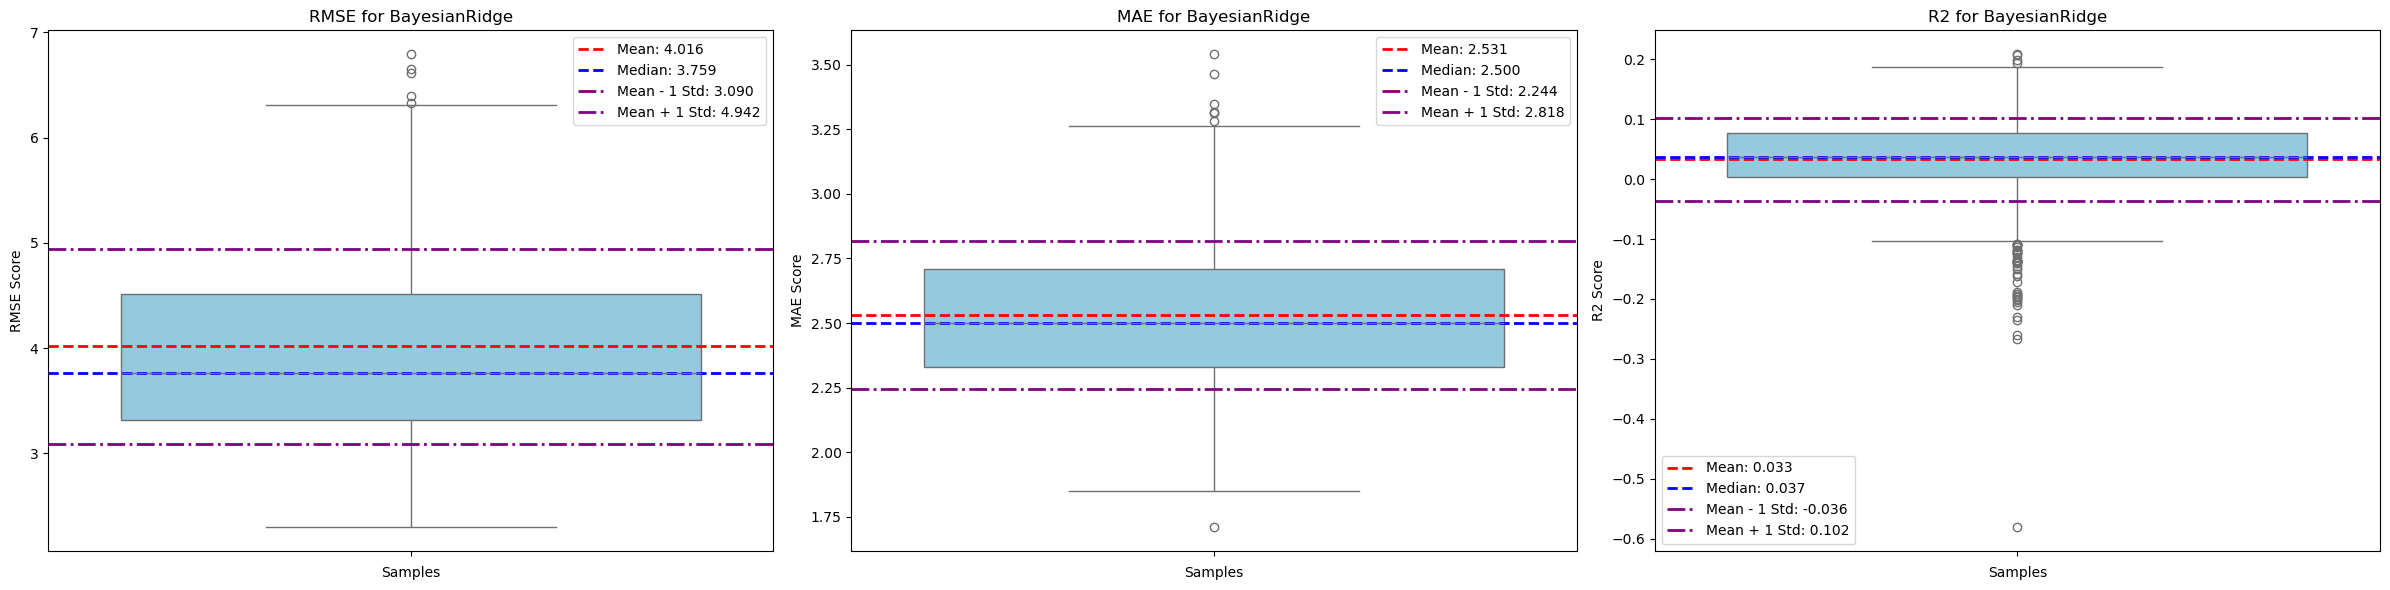

Model: SVR


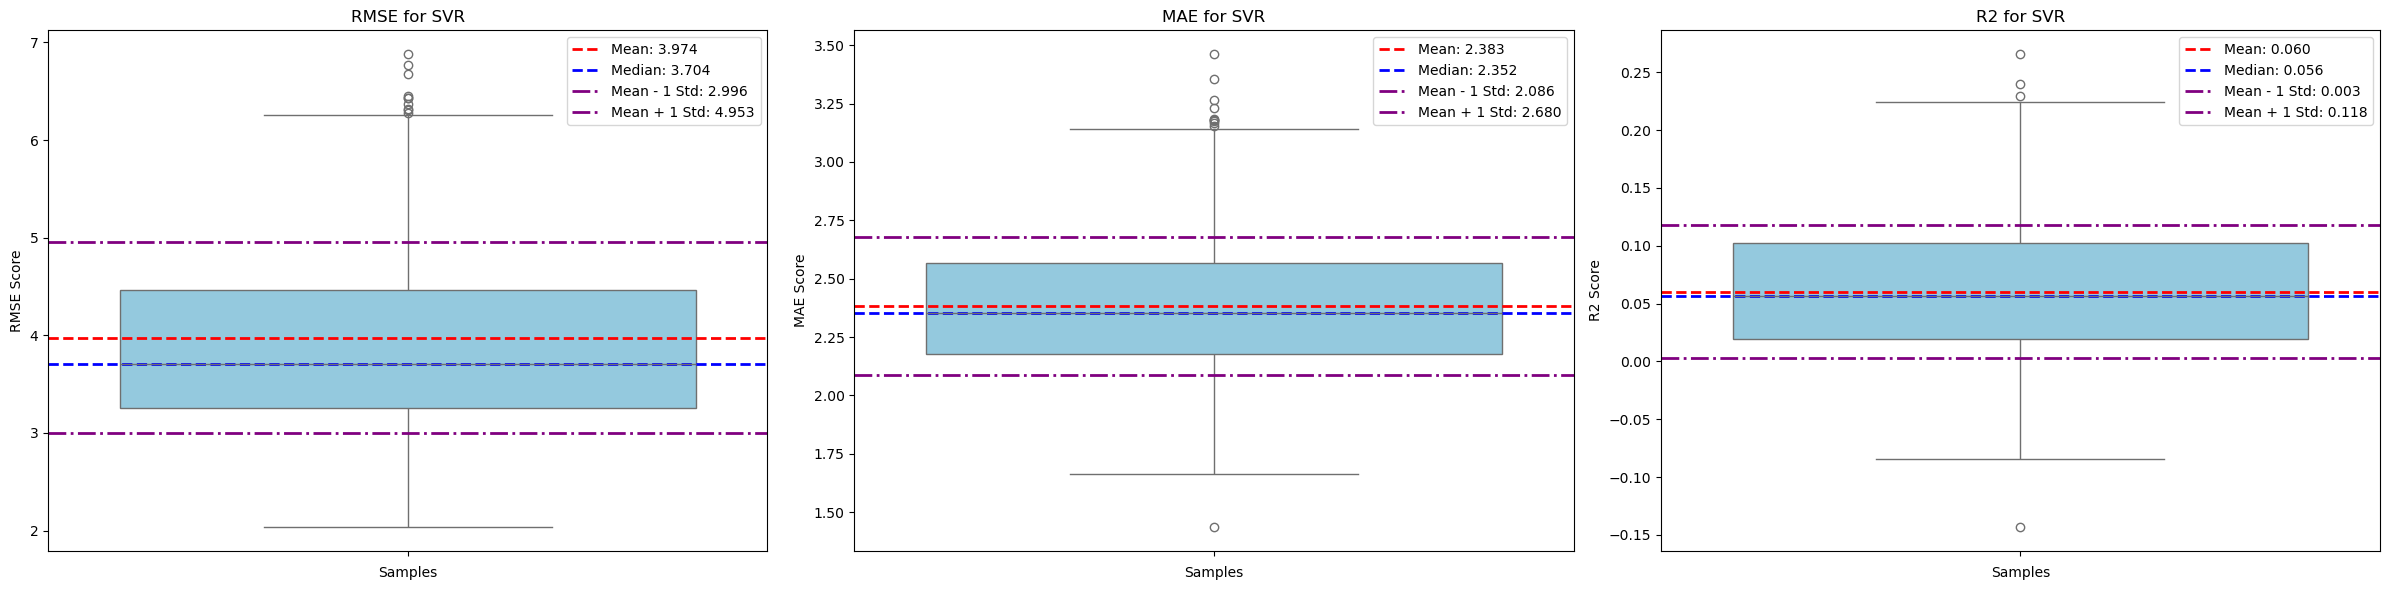

In [19]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}.pkl", save=True)
    # Calculate metrics
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])

</p>Based on the results from k-fold cross-validation, we can see that the model that seems most promising is the SVR, since it has the lowest mean absolute error (MAE), the lowest root mean squared error (RMSE) and the highest R2 score. Regarding R2, the overall distributions also show the same picture as most of the values for the SVR are found in a range higher than the other models, while it is interesting that the R2 for the ElasticNet is mostly negative, which shows that it is likely to be the least reliable. The same seems to hold true for the rest metric plots as well, as RMSE and MAE are smaller for SVR than for the other models, with Bayesian Ridge being second best and slightly better than Elastic Net</p>

Model: ElasticNet


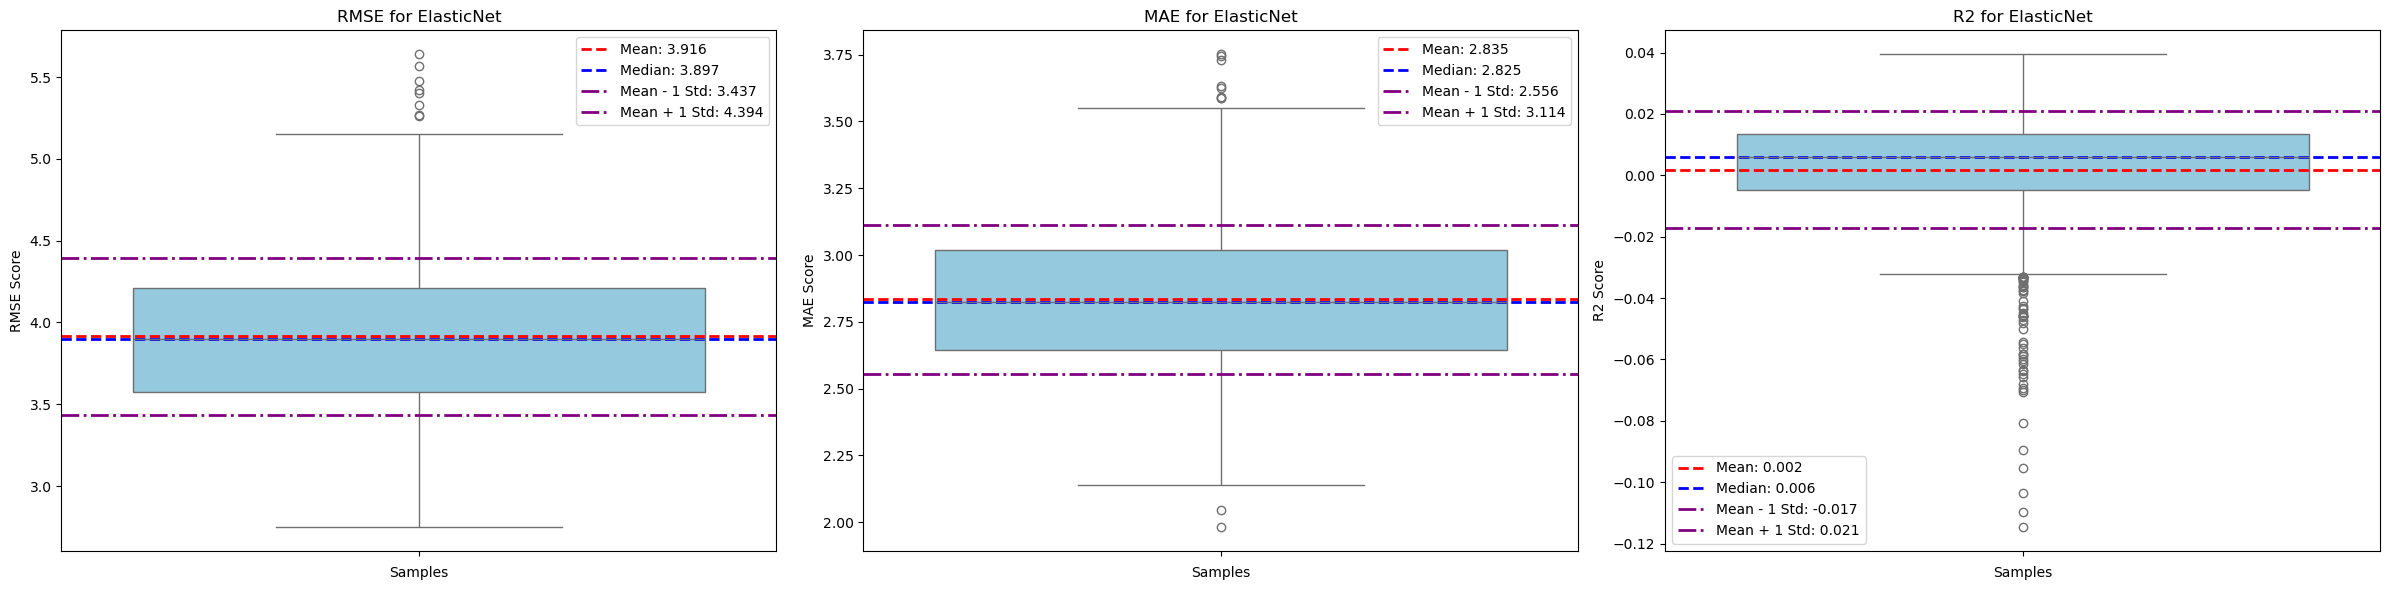

Model: BayesianRidge


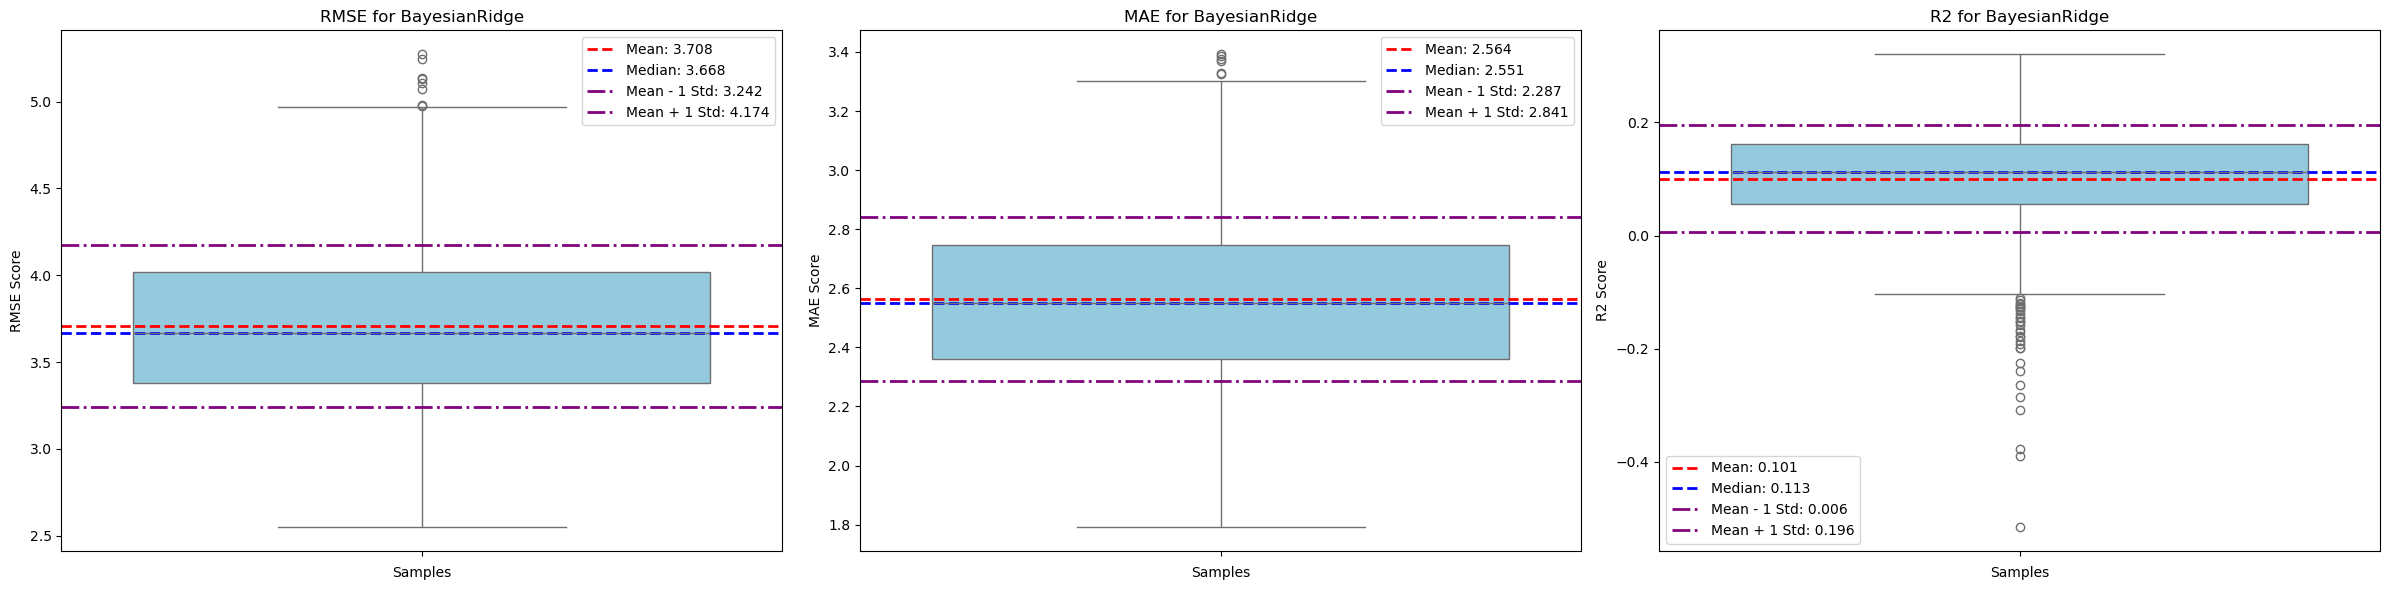

Model: SVR


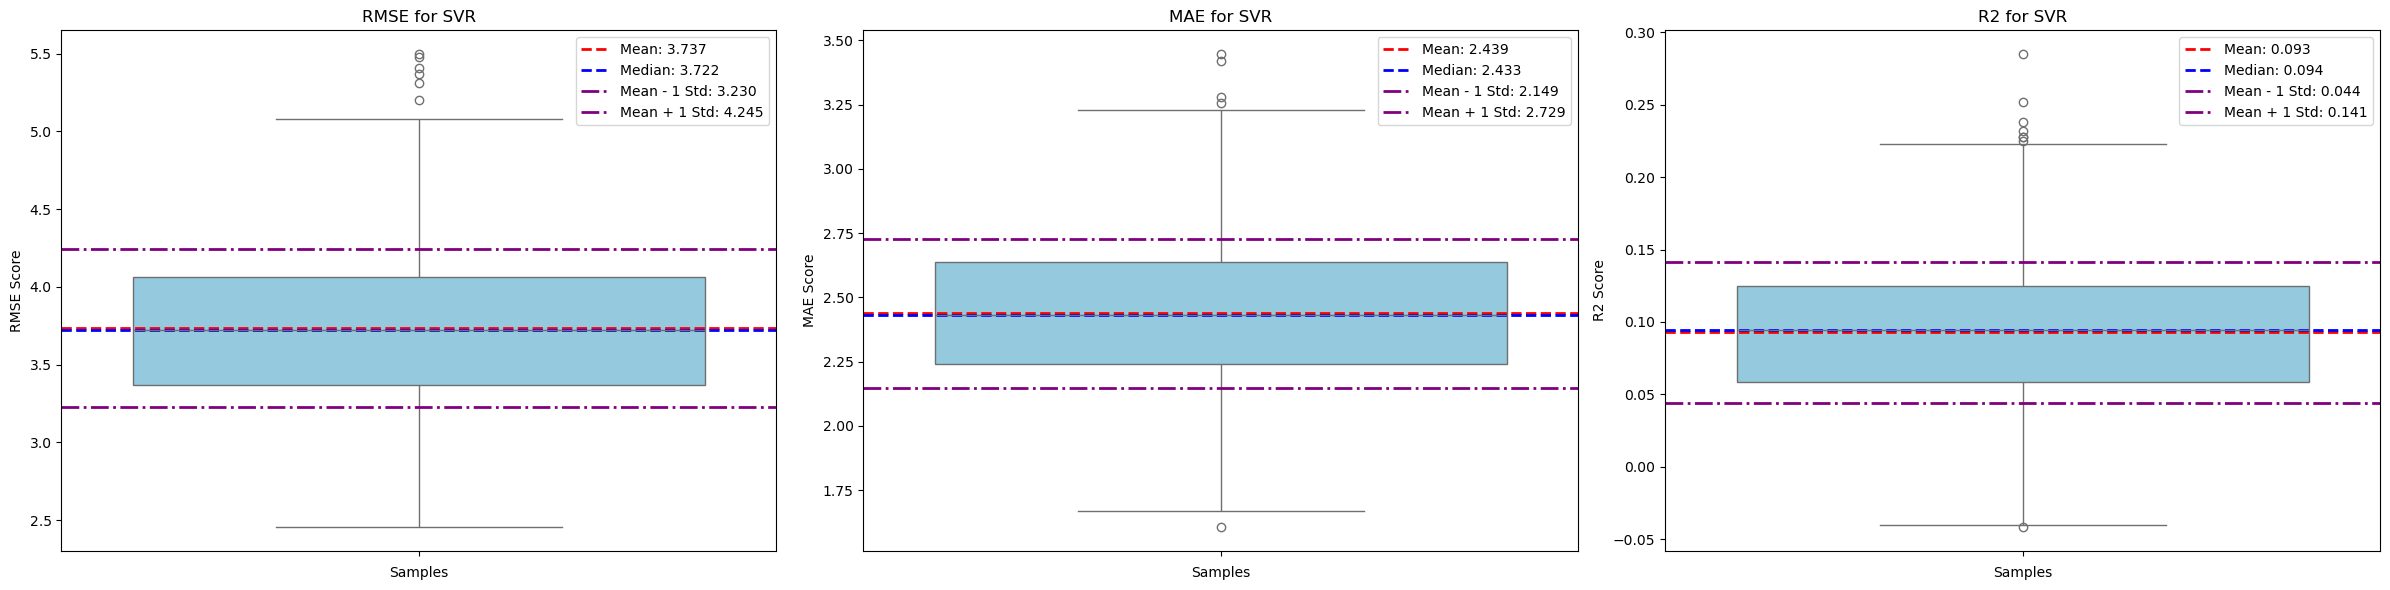

In [20]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline)
    # Calculate metrics
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2= functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])


</p>In order to get enough metrics from one evaluation set we used bootstrapping. More specifically the `resample` function from sklearn which lets sample from a dataset with replacement. The proceedure was repeated 100 times and the metrics were plotted as boxplots. The evaluation here seems to show that SVR and BayesianRidge perform the best as the scores are similar for both models, with ElasticNet performing worse.</p>
<hr>

## Feature Selection
<p>In this section, we will perform a grid search for each baseline model in order to assess the best feature selection method among `PCA`, `KernelPCA` and `RFE` based on `Root Mean Squared Error`.</p>

</p>

In [21]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(model.__class__.__name__)
    grid = functions.grid_search(model, x, y, cv=5, scoring='neg_root_mean_squared_error')
    print("Best parameters:", grid.best_params_)
    print("Best score:", grid.best_score_)

ElasticNet
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 50}
Best score: -4.0911533489601615
BayesianRidge
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 30}
Best score: -4.050556615384229
SVR
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 95}
Best score: -4.013586410812309


ElasticNet
Optimal number of features: 7
Selected features: ['Alistipes putredinis', 'Desulfonispora thiosulfatigenes', 'Ruminococcus champanellensis', 'Sporobacter termitidis', 'Clostridium clariflavum', 'Clostridium symbiosum', 'Eubacterium sulci']
Mean negative RMSE for optimal features (7): -4.1667


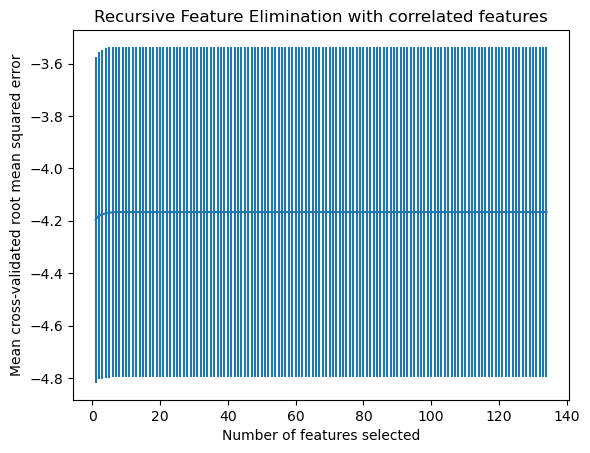

BayesianRidge
Optimal number of features: 134
Selected features: ['Acholeplasma axanthum', 'Acidaminococcus fermentans', 'Acidaminococcus intestini', 'Actinomyces lingnae', 'Akkermansia muciniphila', 'Alistipes finegoldii', 'Alistipes indistinctus', 'Alistipes obesi', 'Alistipes onderdonkii', 'Alistipes putredinis', 'Alistipes shahii', 'Alistipes sp. RMA 9912', 'Alistipes timonensis', 'Anaerofilum pentosovorans', 'Anaerofustis stercorihominis', 'Anaerostipes butyraticus', 'Anaerostipes caccae', 'Anaerotruncus colihominis', 'Bacillus megaterium', 'Bacillus nealsonii', 'Bacteroides eggerthii', 'Bacteroides fragilis', 'Bacteroides gallinarum', 'Bacteroides graminisolvens', 'Bacteroides intestinalis', 'Bacteroides massiliensis', 'Bacteroides ovatus', 'Bacteroides plebeius', 'Bacteroides salyersiae', 'Barnesiella viscericola', 'Bifidobacterium bifidum', 'Bifidobacterium pseudocatenulatum', 'Bifidobacterium saguini', 'Bifidobacterium tsurumiense', 'Bilophila wadsworthia', 'Blautia coccoides'

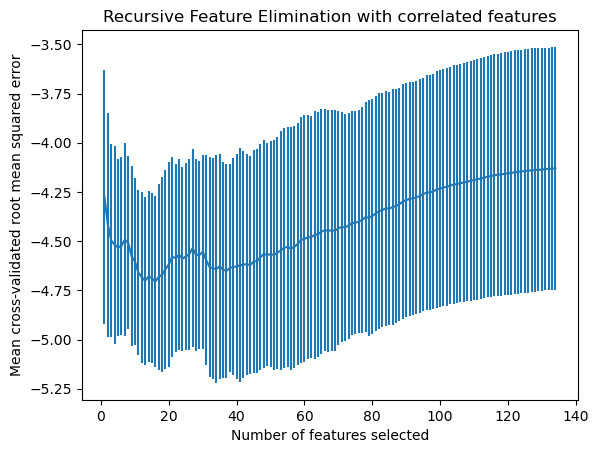

In [22]:
from sklearn.feature_selection import RFECV
models = [ElasticNet(), BayesianRidge()]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
features_per_model = {}
for model in models:
    features_per_model[model.__class__.__name__] = []
    print(model.__class__.__name__)
    rfecv = RFECV(estimator=model, 
                step=1, cv=cv, 
                scoring='neg_root_mean_squared_error',
                min_features_to_select=1
                )
    rfecv.fit(x, y)
    print('Optimal number of features: %d' % rfecv.n_features_)
    # If x is a DataFrame, this will list the selected features by name.
    selected_features = x.columns[rfecv.support_]
    selected_features_list = selected_features.tolist()
    features_per_model[model.__class__.__name__].extend(selected_features_list)
    print("Selected features:", selected_features_list)
    # Number of features tested by RFE:
    n_features_list = np.arange(
        rfecv.min_features_to_select, 
        x.shape[1] + 1,               
        rfecv.step                     
    )

    # Make sure we only take as many points as in cv_results_:
    n_features_list = n_features_list[:len(rfecv.cv_results_["mean_test_score"])]
    optimal_index = list(n_features_list).index(rfecv.n_features_)
    optimal_score = rfecv.cv_results_["mean_test_score"][optimal_index]
    print("Mean negative RMSE for optimal features ({}): {:.4f}".format(rfecv.n_features_, optimal_score))

    # Now you can plot
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.errorbar(
        x=n_features_list,
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean cross-validated root mean squared error")
    plt.title("Recursive Feature Elimination with correlated features")
    plt.show()


In [23]:
# Train each model with its corresponding features
x_mod_elnet = x[features_per_model['ElasticNet']]
x_mod_bayesian = x[features_per_model['BayesianRidge']]
x_val_elnet = val_x[features_per_model['ElasticNet']]
x_val_bayesian = val_x[features_per_model['BayesianRidge']]
print(x_mod_elnet.shape)
print(x_mod_bayesian.shape)

(489, 7)
(489, 134)


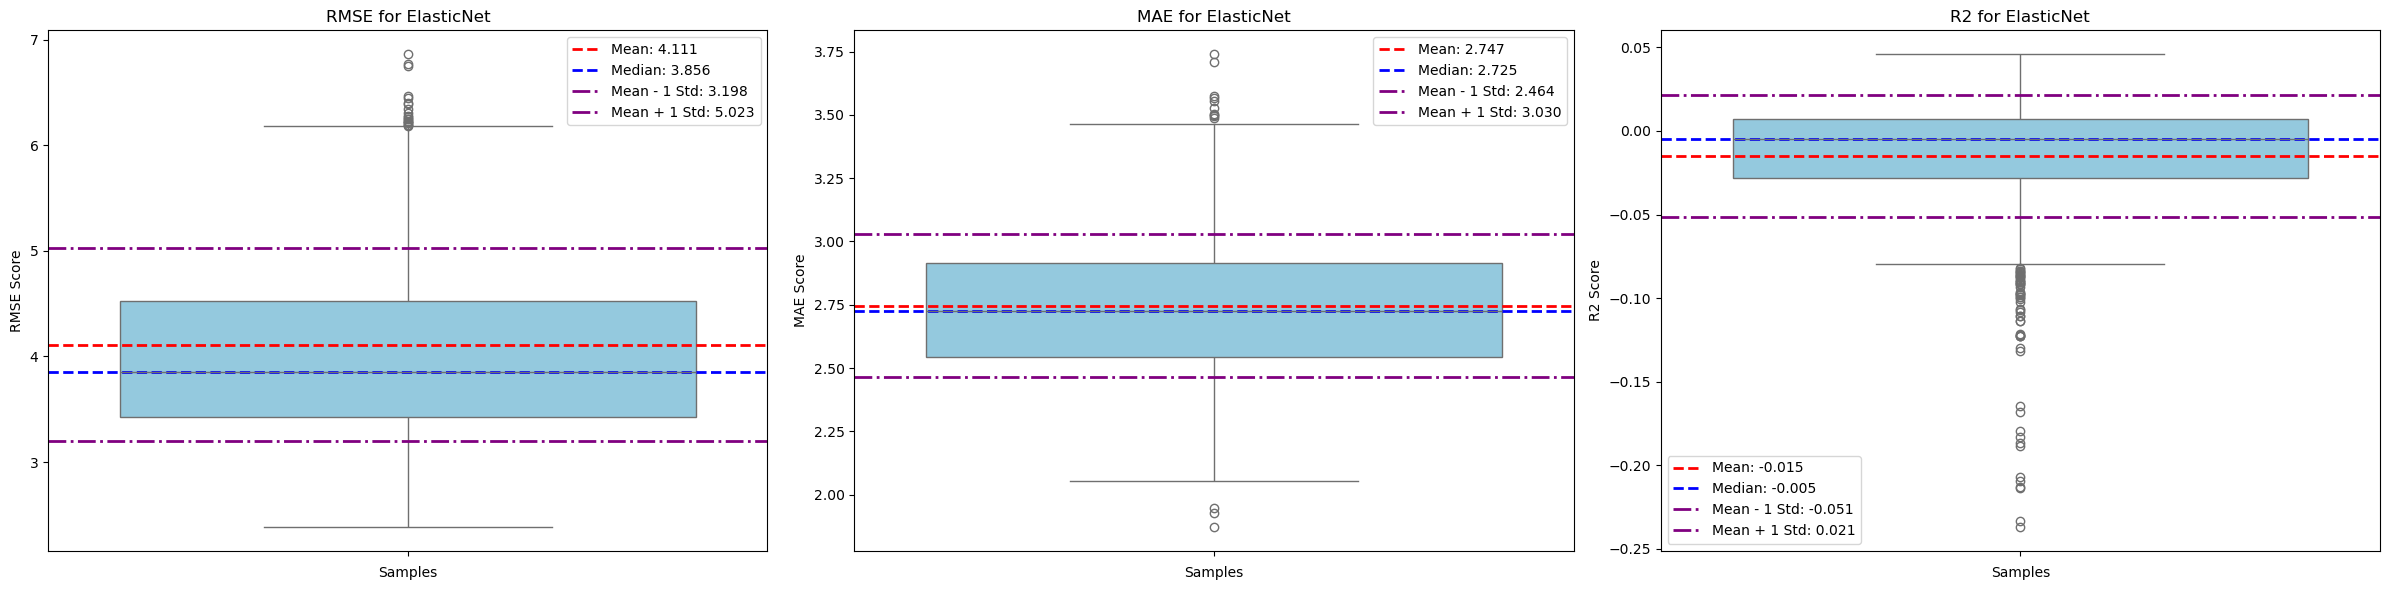

In [24]:
model = ElasticNet()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model)
preds, trained_pipeline = functions.train_model_and_predict(x_mod_elnet, y, x_val_elnet, pipeline, root_path=root, filename=f"{model.__class__.__name__}_rfe.pkl", save=True)
# Calculate metrics
scores = functions.bootstrap(x_mod_elnet, y, x_val_elnet, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
# Create a boxplot
functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])


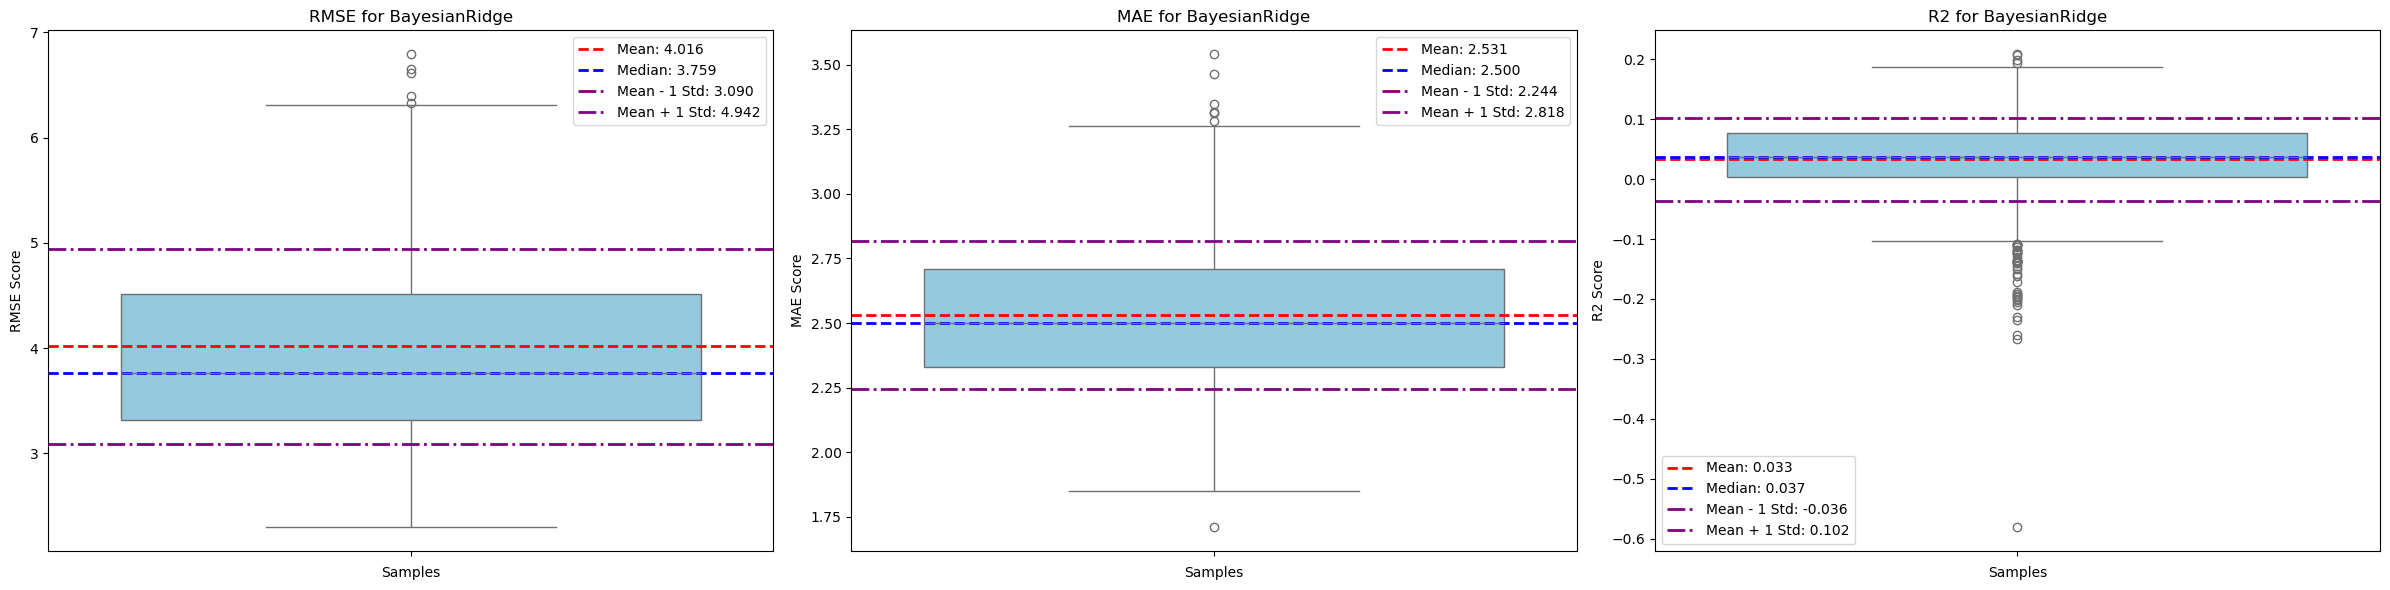

In [25]:
model = BayesianRidge()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model)
preds, trained_pipeline = functions.train_model_and_predict(x_mod_bayesian, y, x_val_bayesian, pipeline, root_path=root, filename=f"{model.__class__.__name__}_rfe.pkl", save=True)
# Calculate metrics
scores = functions.bootstrap(x_mod_bayesian, y, x_val_bayesian, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
# Create a boxplot
functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])


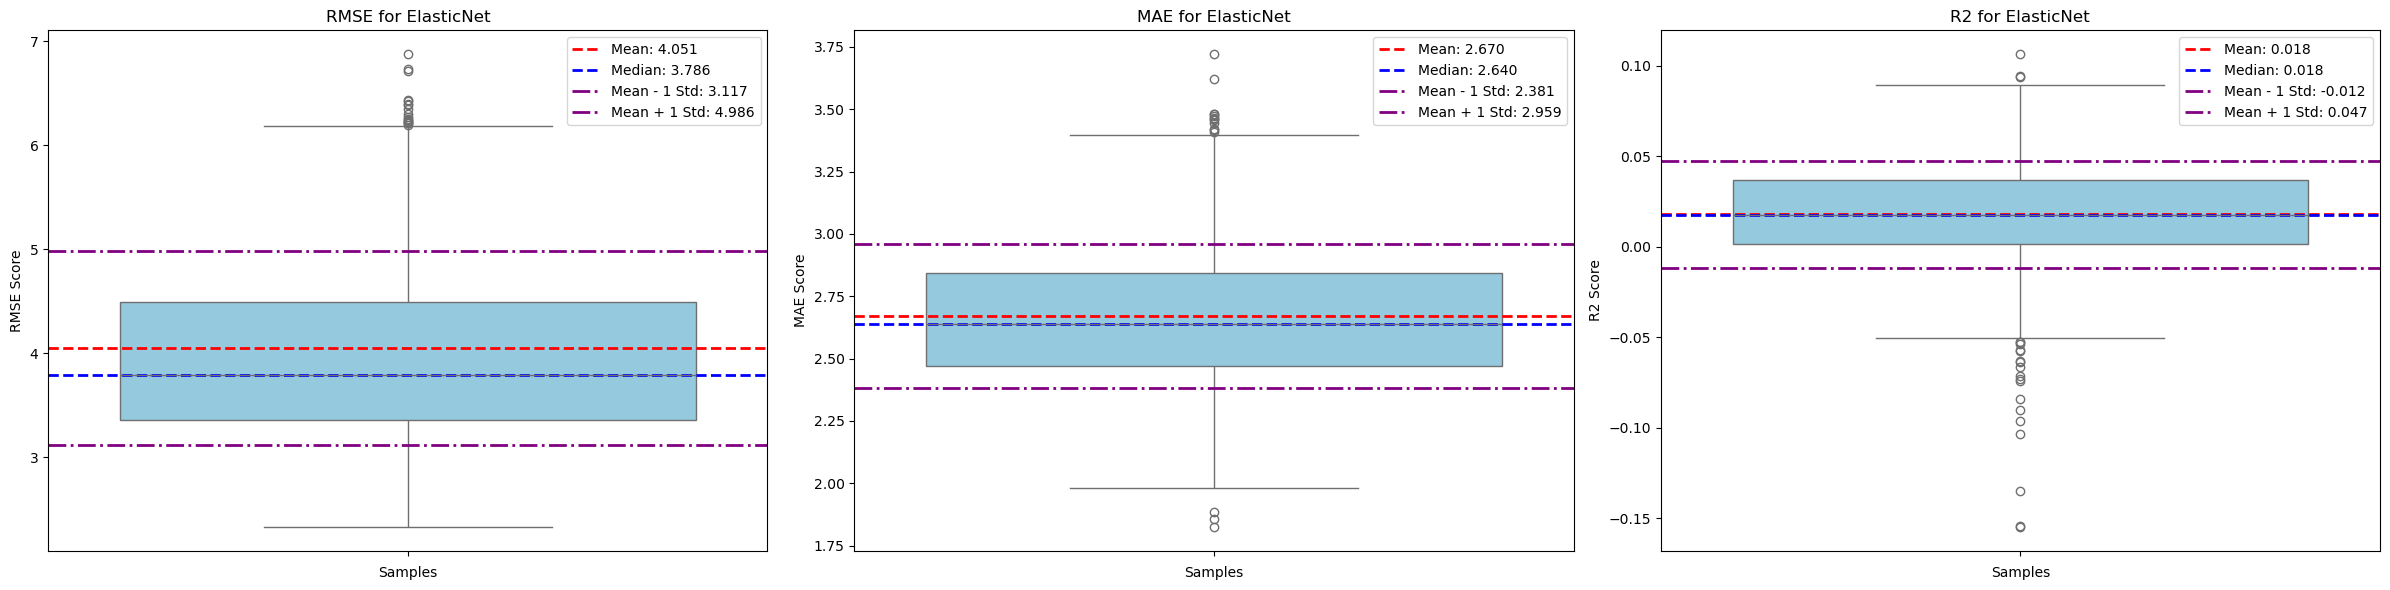

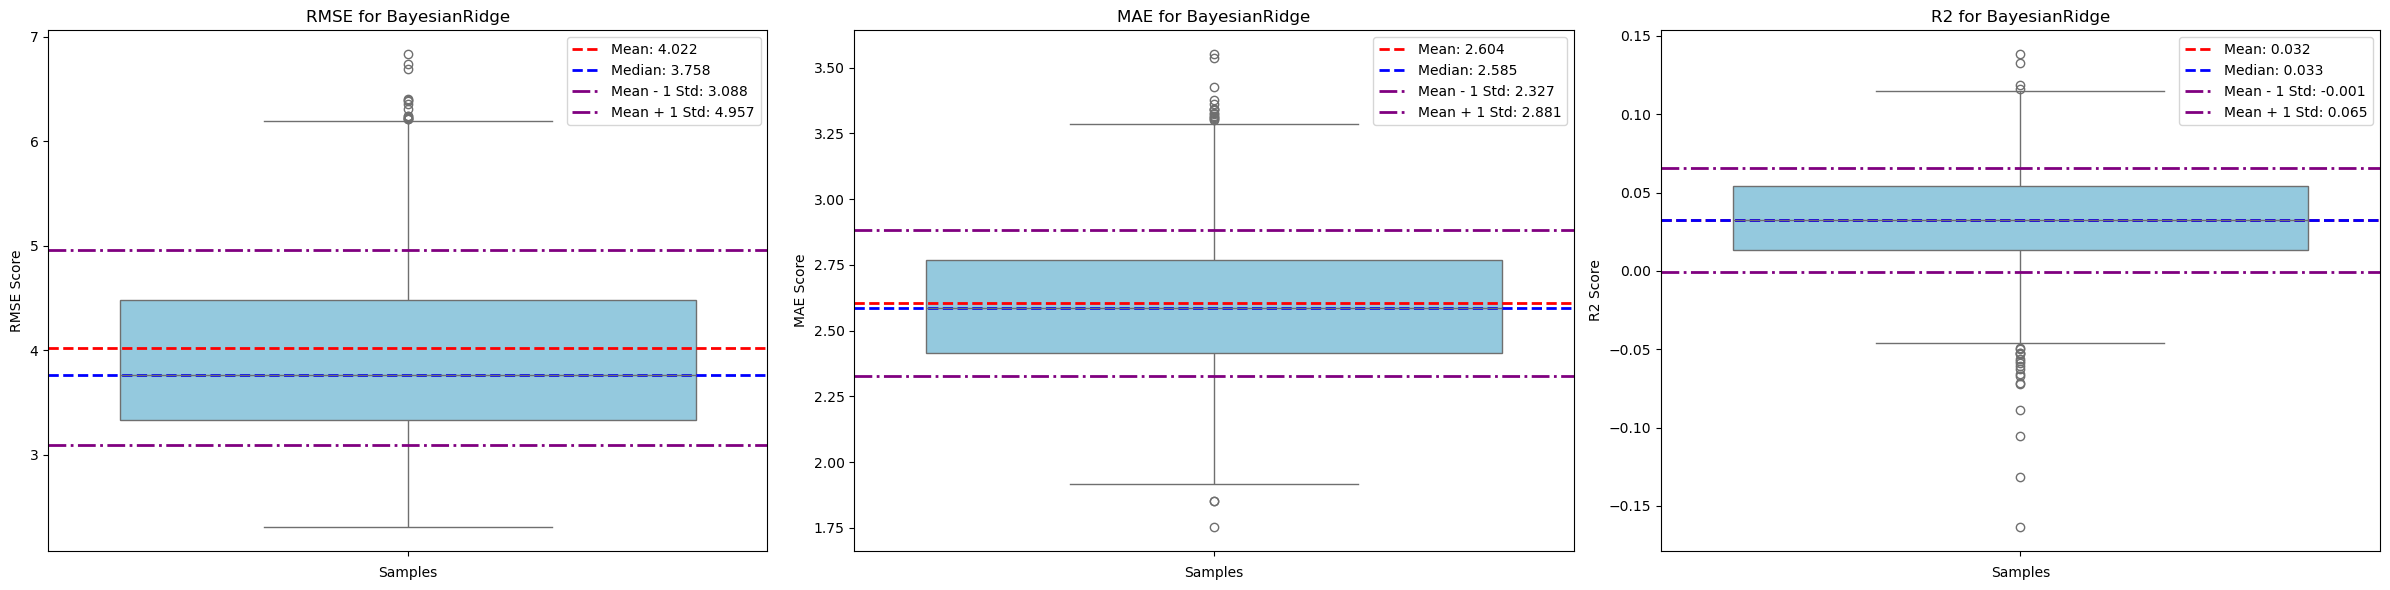

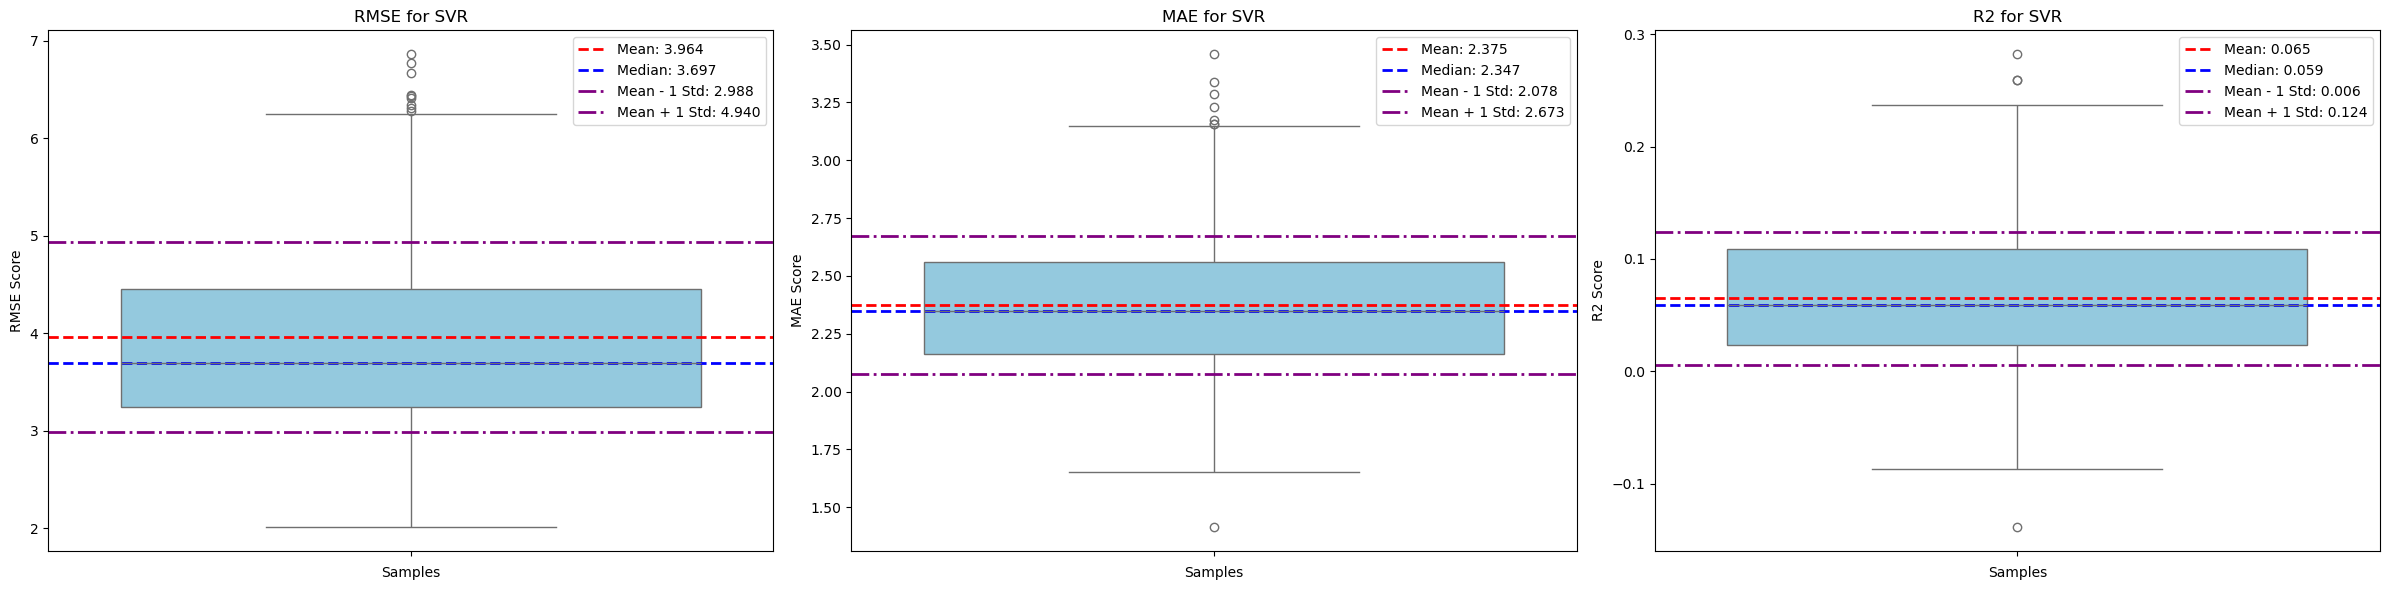

In [8]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    if model.__class__.__name__ == 'ElasticNet':
# Create a pipeline for each baseline model
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=50))
    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=30))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=95))
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_pca.pkl", save=True)
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])



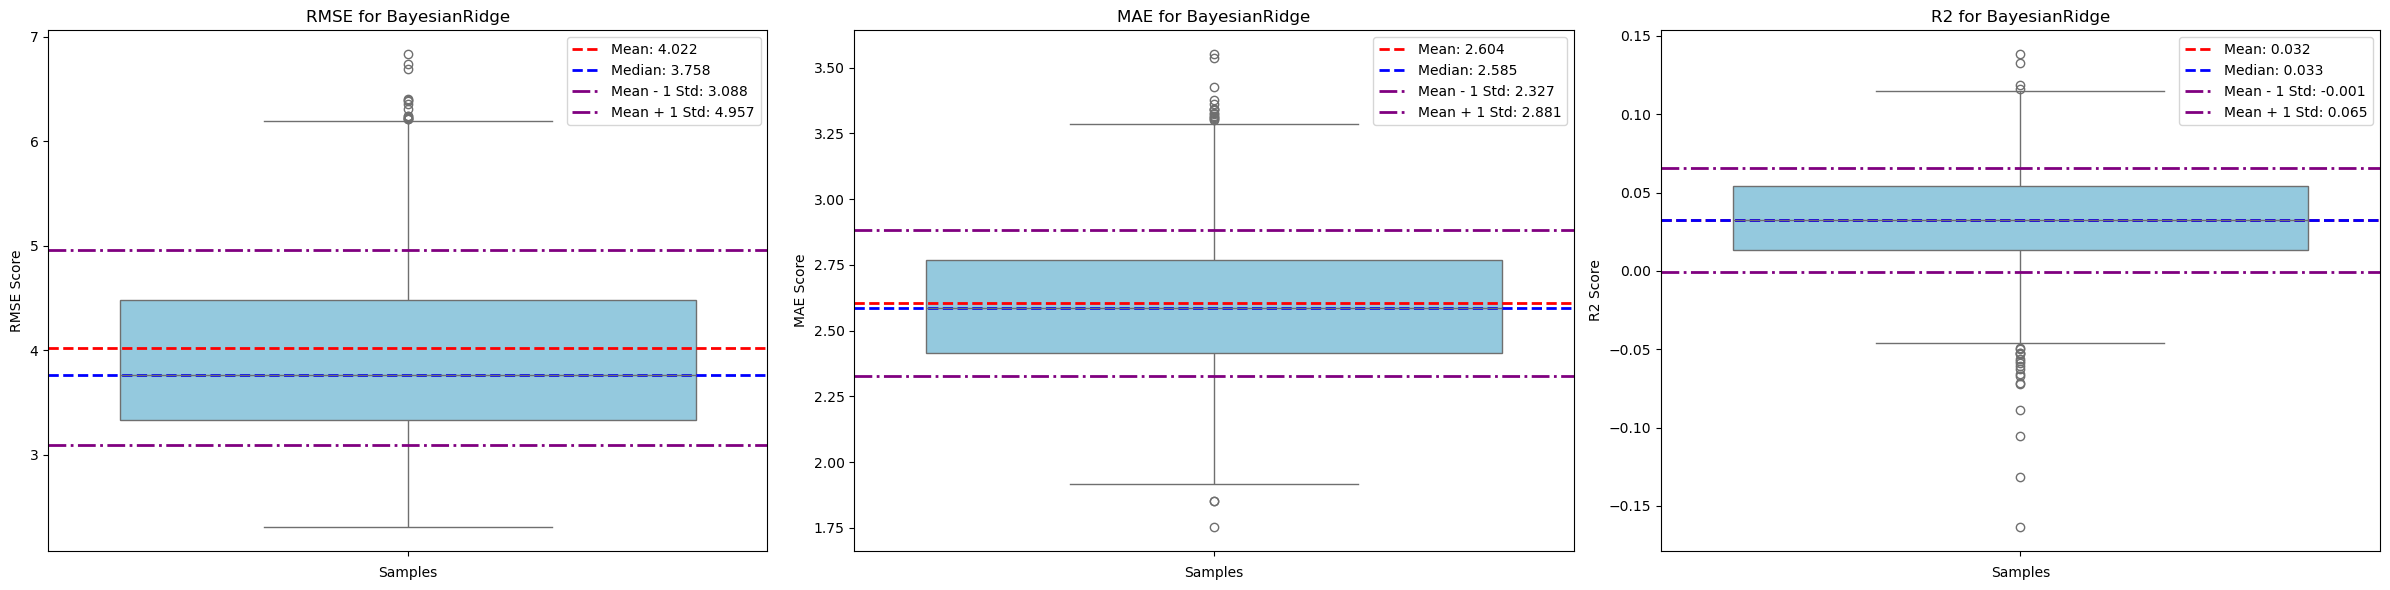

In [27]:
model = BayesianRidge()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=30))
preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_pca.pkl", save=True)
scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
# Create a boxplot
functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])

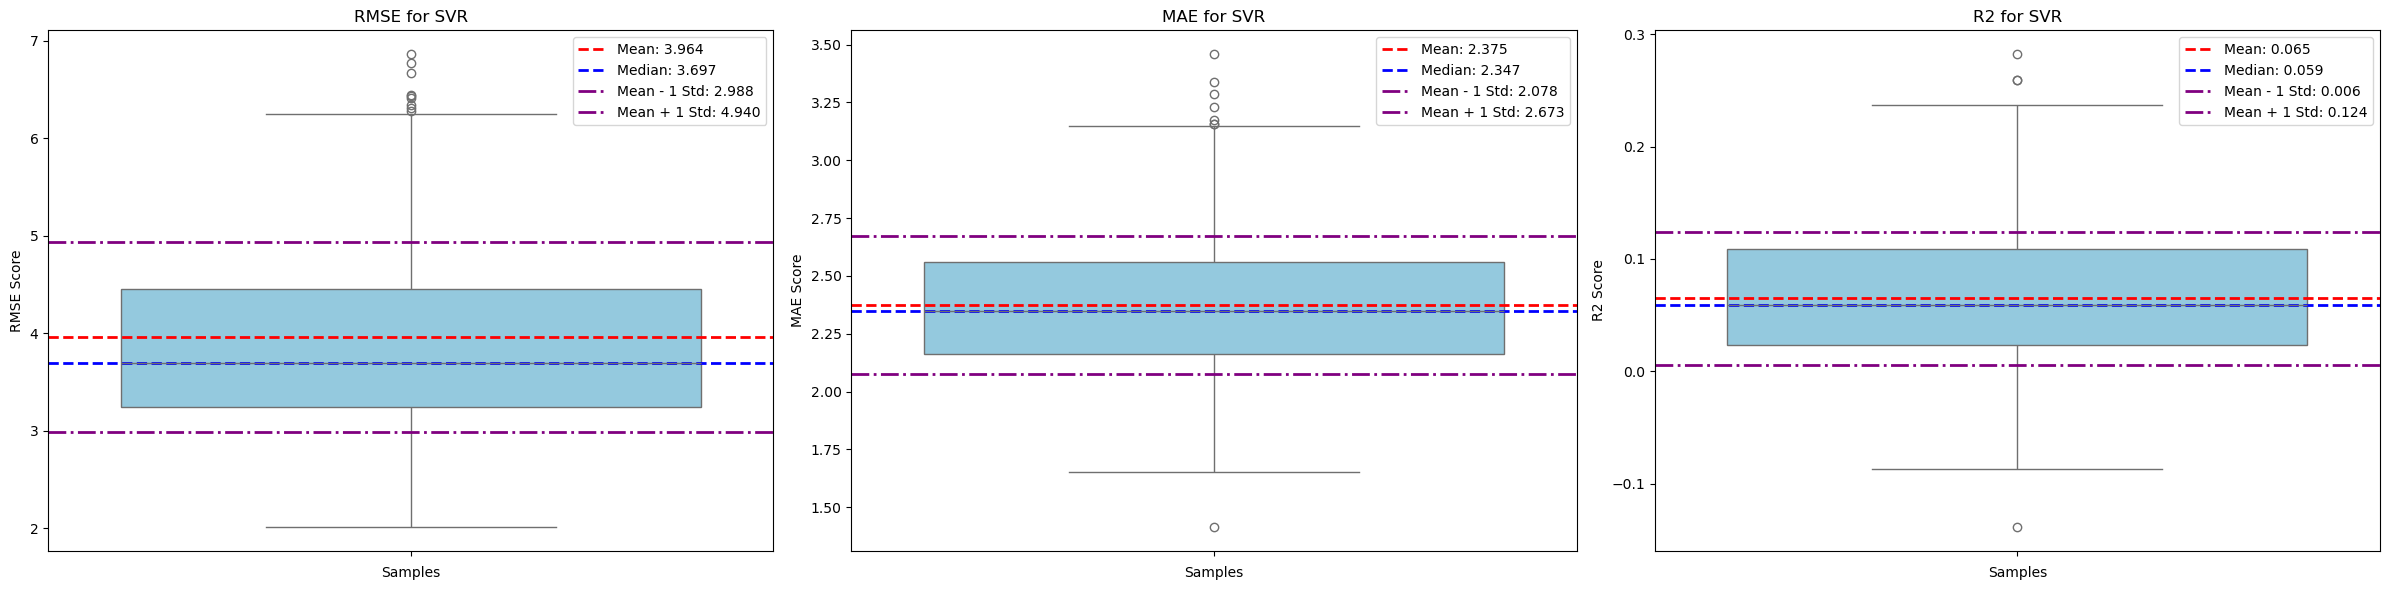

In [28]:
model = SVR()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=95))
preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_pca.pkl", save=True)
scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
# Create a boxplot
functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])

ElasticNet


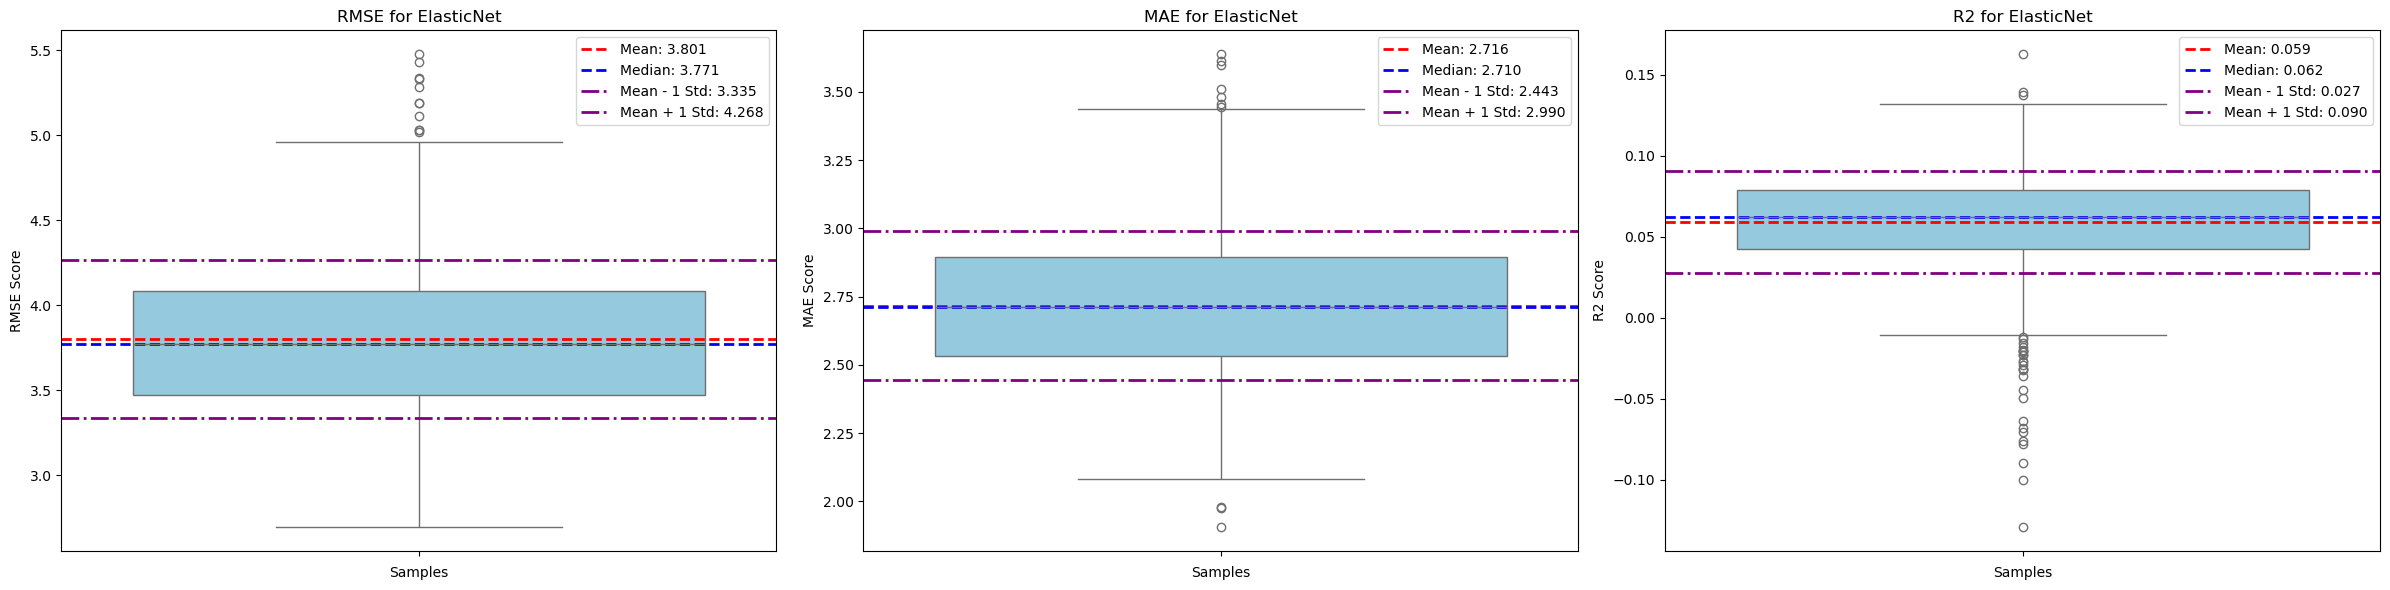

BayesianRidge


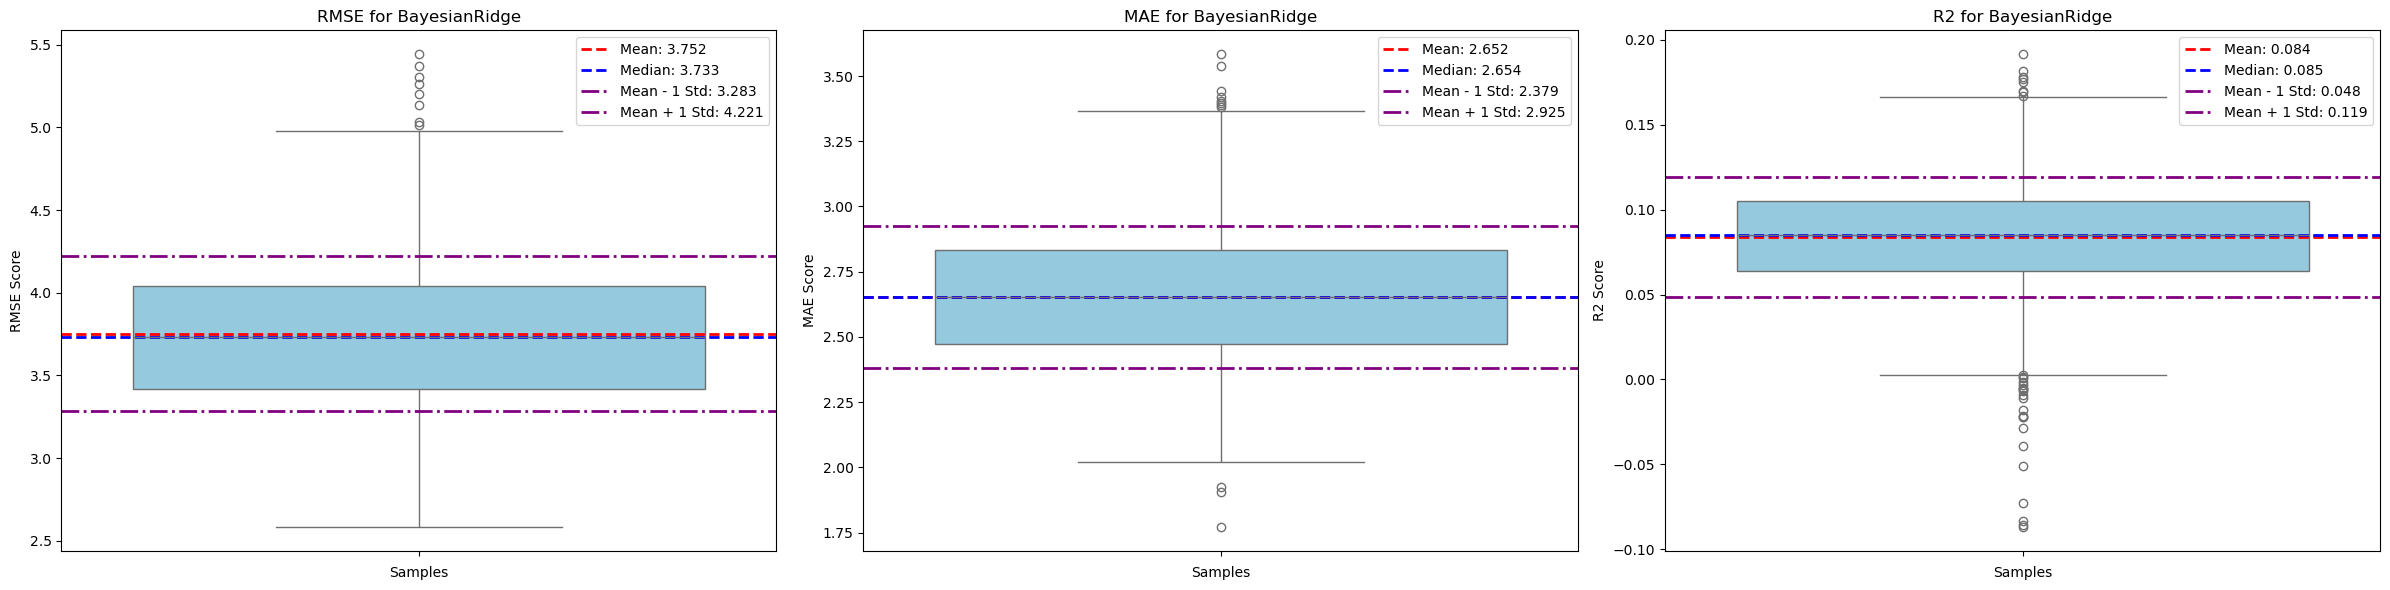

SVR


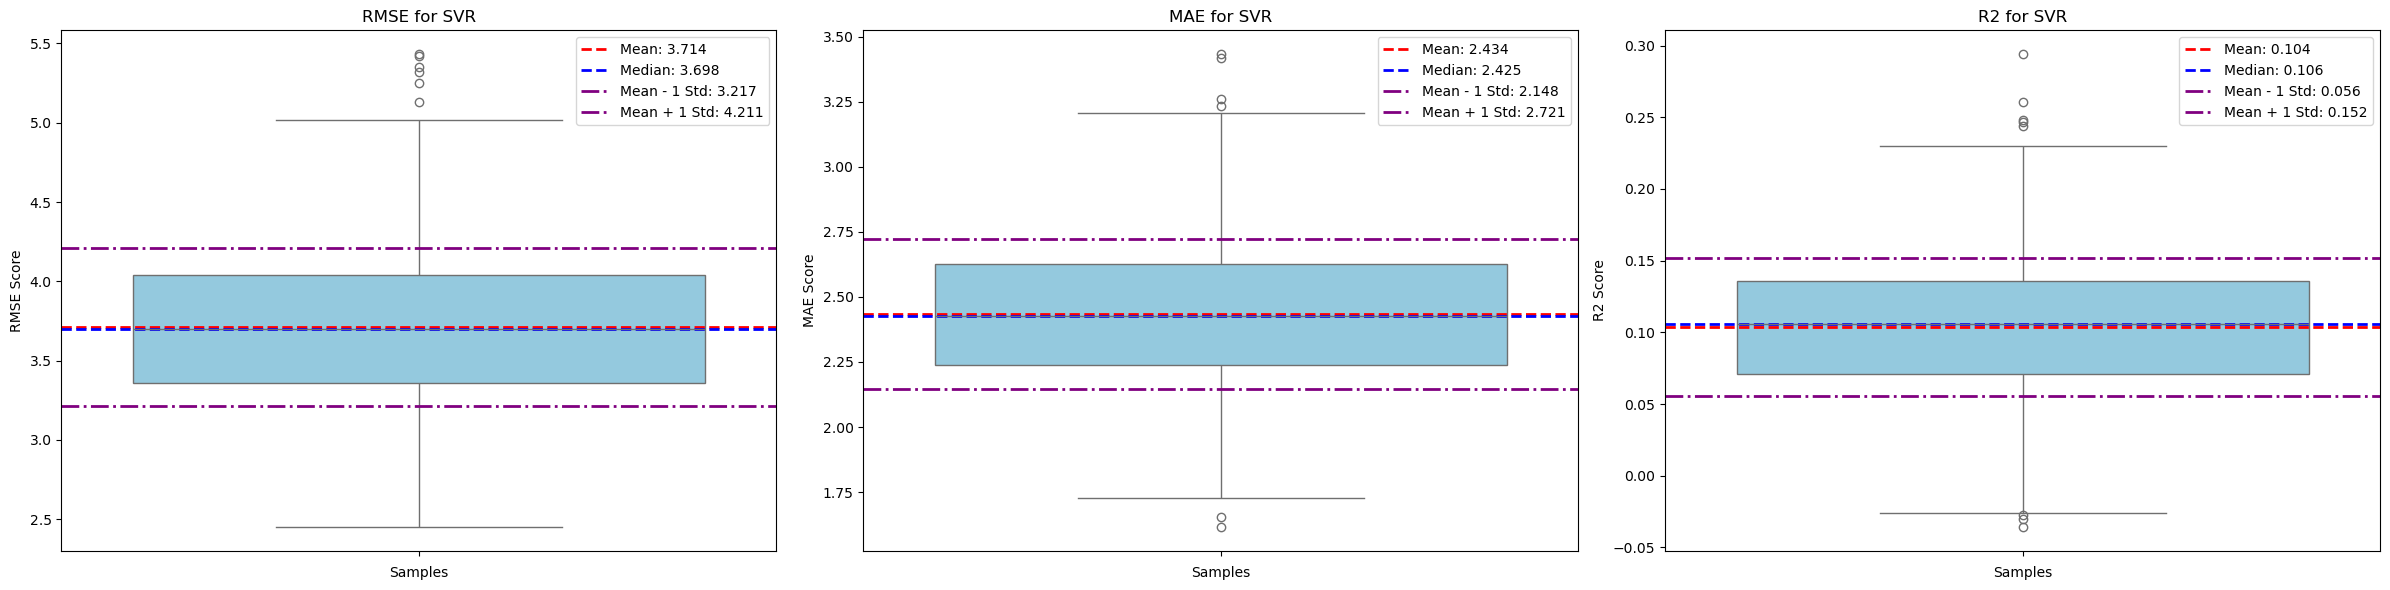

In [4]:
models = [ElasticNet(), BayesianRidge(), SVR()]

for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'ElasticNet':
       pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=50))
    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=30))
    else:
       pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=95))
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])
    
    

In [ ]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
# Run Optuna optimization
        study = optuna.create_study(direction="maximize")
        # I had to use chatgpt for the following line, to figure out how to pass the model and x and y to the optuna_objective function
        study.optimize(lambda trial: functions.optuna_objective(trial, model, x, y), n_trials=100)
        # Best hyperparameters
        print("Study statistics: ")
        print("  Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
                print(f"    {key}: {value}")

[I 2025-03-19 20:38:52,331] A new study created in memory with name: no-name-33b8088b-fb4b-41eb-9b58-a48b7f12acf1
[I 2025-03-19 20:38:52,410] Trial 0 finished with value: -4.167824204415766 and parameters: {'alpha': 9.901709408470161, 'l1_ratio': 0.20653129549592886}. Best is trial 0 with value: -4.167824204415766.
[I 2025-03-19 20:38:52,478] Trial 1 finished with value: -4.167824204415766 and parameters: {'alpha': 6.981556481456421, 'l1_ratio': 0.696679280773833}. Best is trial 0 with value: -4.167824204415766.
[I 2025-03-19 20:38:52,560] Trial 2 finished with value: -4.167824204415766 and parameters: {'alpha': 5.312876046156959, 'l1_ratio': 0.6382396996946701}. Best is trial 0 with value: -4.167824204415766.
[I 2025-03-19 20:38:52,661] Trial 3 finished with value: -4.167824204415766 and parameters: {'alpha': 6.668998606595474, 'l1_ratio': 0.724407414175758}. Best is trial 0 with value: -4.167824204415766.
[I 2025-03-19 20:38:52,732] Trial 4 finished with value: -4.167824204415766 and

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -4.079103206506668
  Params: 
    alpha: 1.6174922915452128
    l1_ratio: 0.003659782920642262


[I 2025-03-19 20:39:01,594] Trial 2 finished with value: -4.107251881086785 and parameters: {'alpha_1': 2.0796515541968812e-08, 'lambda_1': 1.667464880985613e-06, 'alpha_2': 2.277359220125734e-06, 'lambda_2': 3.2091097205615545e-06}. Best is trial 2 with value: -4.107251881086785.
[I 2025-03-19 20:39:01,683] Trial 3 finished with value: -4.107254171384724 and parameters: {'alpha_1': 2.922782785046629e-06, 'lambda_1': 1.0859431748244652e-06, 'alpha_2': 1.5959585037621163e-05, 'lambda_2': 1.90212413476403e-07}. Best is trial 2 with value: -4.107251881086785.
[I 2025-03-19 20:39:01,784] Trial 4 finished with value: -4.107250269867457 and parameters: {'alpha_1': 1.3321495761715925e-05, 'lambda_1': 2.940295887735675e-06, 'alpha_2': 1.6283282157104324e-08, 'lambda_2': 5.337871504262691e-06}. Best is trial 4 with value: -4.107250269867457.
[I 2025-03-19 20:39:01,880] Trial 5 finished with value: -4.1072515878863864 and parameters: {'alpha_1': 1.329192497427913e-07, 'lambda_1': 5.4646119360410

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -4.107178381872579
  Params: 
    alpha_1: 4.710714054814993e-07
    lambda_1: 1.2415064644983772e-05
    alpha_2: 7.098980122317167e-07
    lambda_2: 9.98609837502576e-05


[I 2025-03-19 20:39:13,375] Trial 0 finished with value: -4.310140417890419 and parameters: {'C': 2.730098075386091, 'gamma': 'auto', 'epsilon': 0.20573924664577495, 'kernel': 'linear'}. Best is trial 0 with value: -4.310140417890419.
[I 2025-03-19 20:39:13,524] Trial 1 finished with value: -3.9687498479961234 and parameters: {'C': 3.168888891038934, 'gamma': 'scale', 'epsilon': 0.18244610525573848, 'kernel': 'rbf'}. Best is trial 1 with value: -3.9687498479961234.
[I 2025-03-19 20:39:13,640] Trial 2 finished with value: -4.23092023006061 and parameters: {'C': 6.502648631720457, 'gamma': 'scale', 'epsilon': 0.5270527705113738, 'kernel': 'poly', 'degree': 4, 'coef0': 0.021568716485514616}. Best is trial 1 with value: -3.9687498479961234.
[I 2025-03-19 20:39:13,809] Trial 3 finished with value: -5.068153401332212 and parameters: {'C': 9.636536021777104, 'gamma': 'scale', 'epsilon': 0.19344461229730583, 'kernel': 'poly', 'degree': 4, 'coef0': 0.8290512779638087}. Best is trial 1 with valu

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -3.956430661354845
  Params: 
    C: 5.481042585645274
    gamma: scale
    epsilon: 0.0300079986016957
    kernel: rbf


Model: ElasticNet


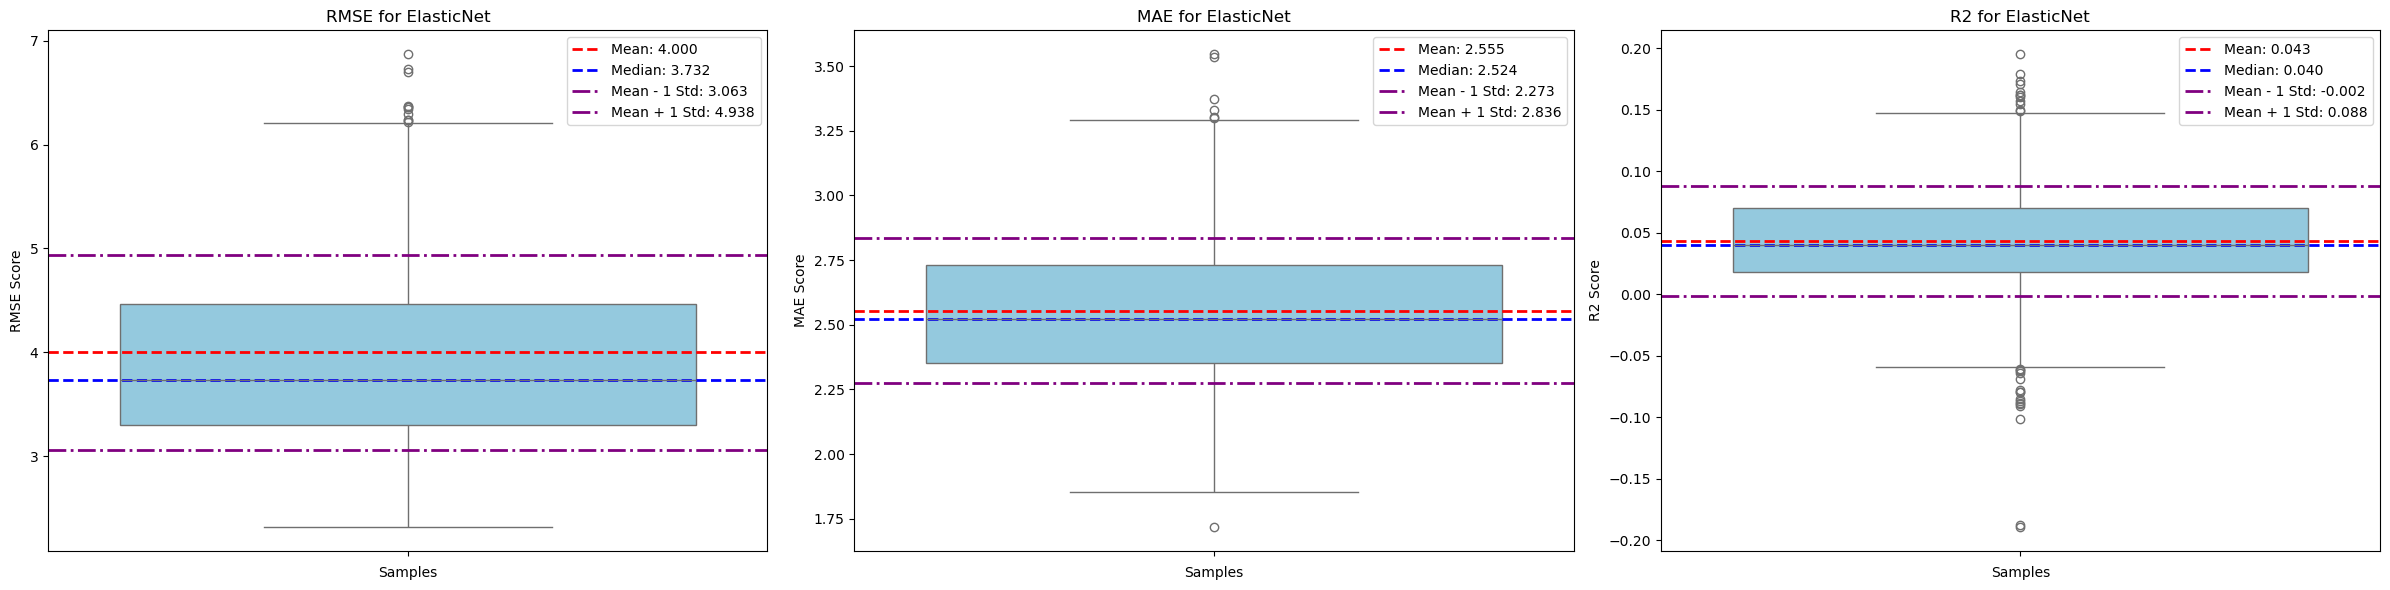

Model: BayesianRidge


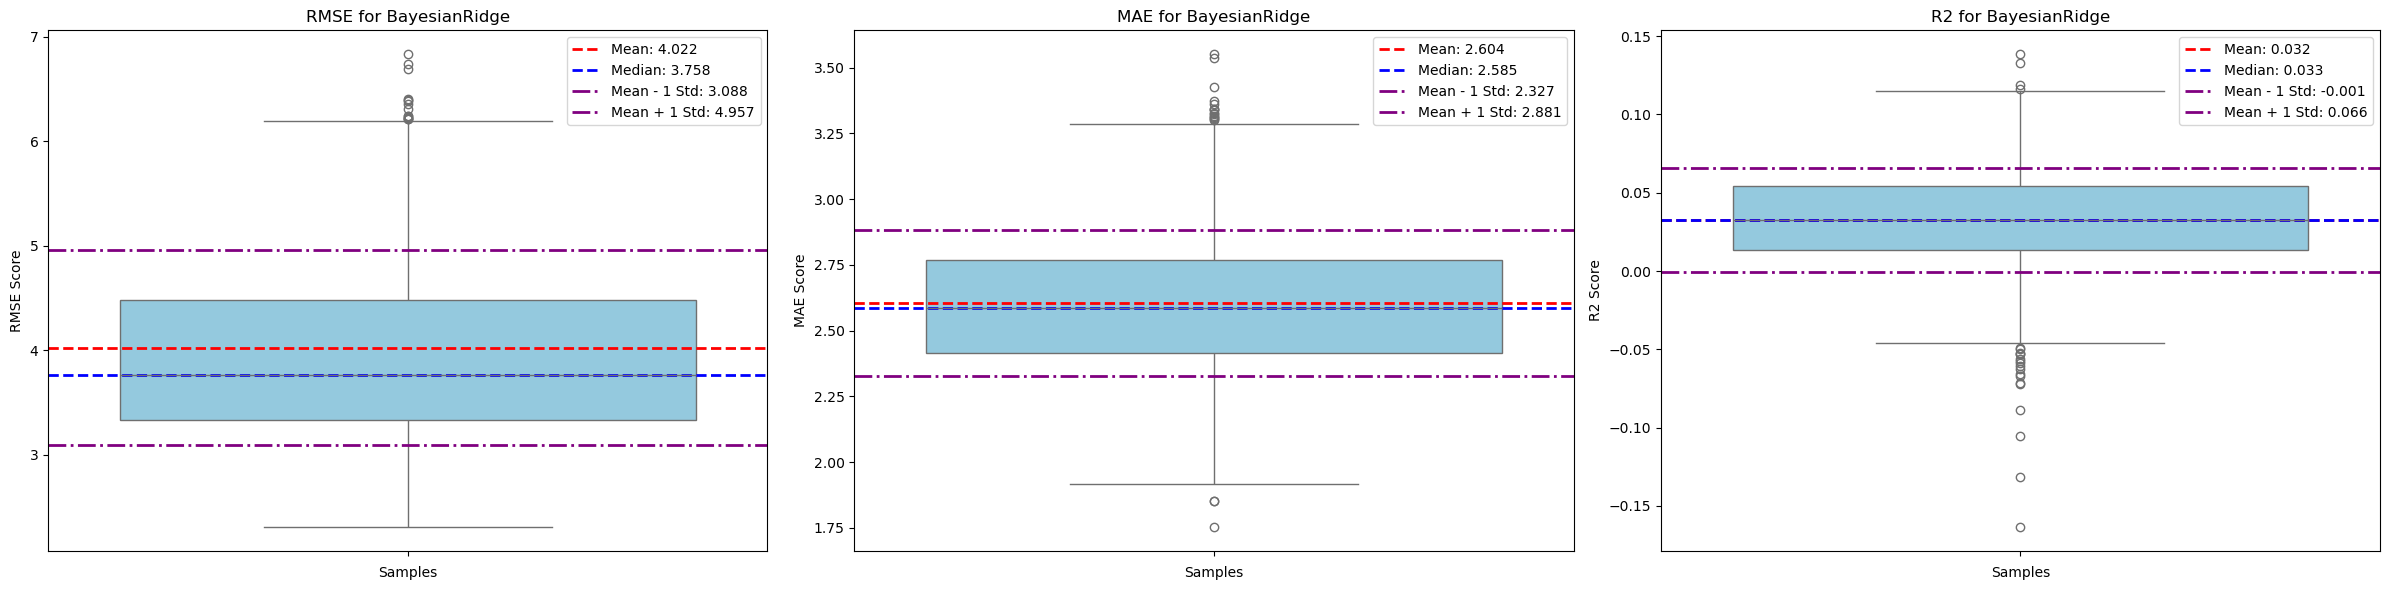

Model: SVR


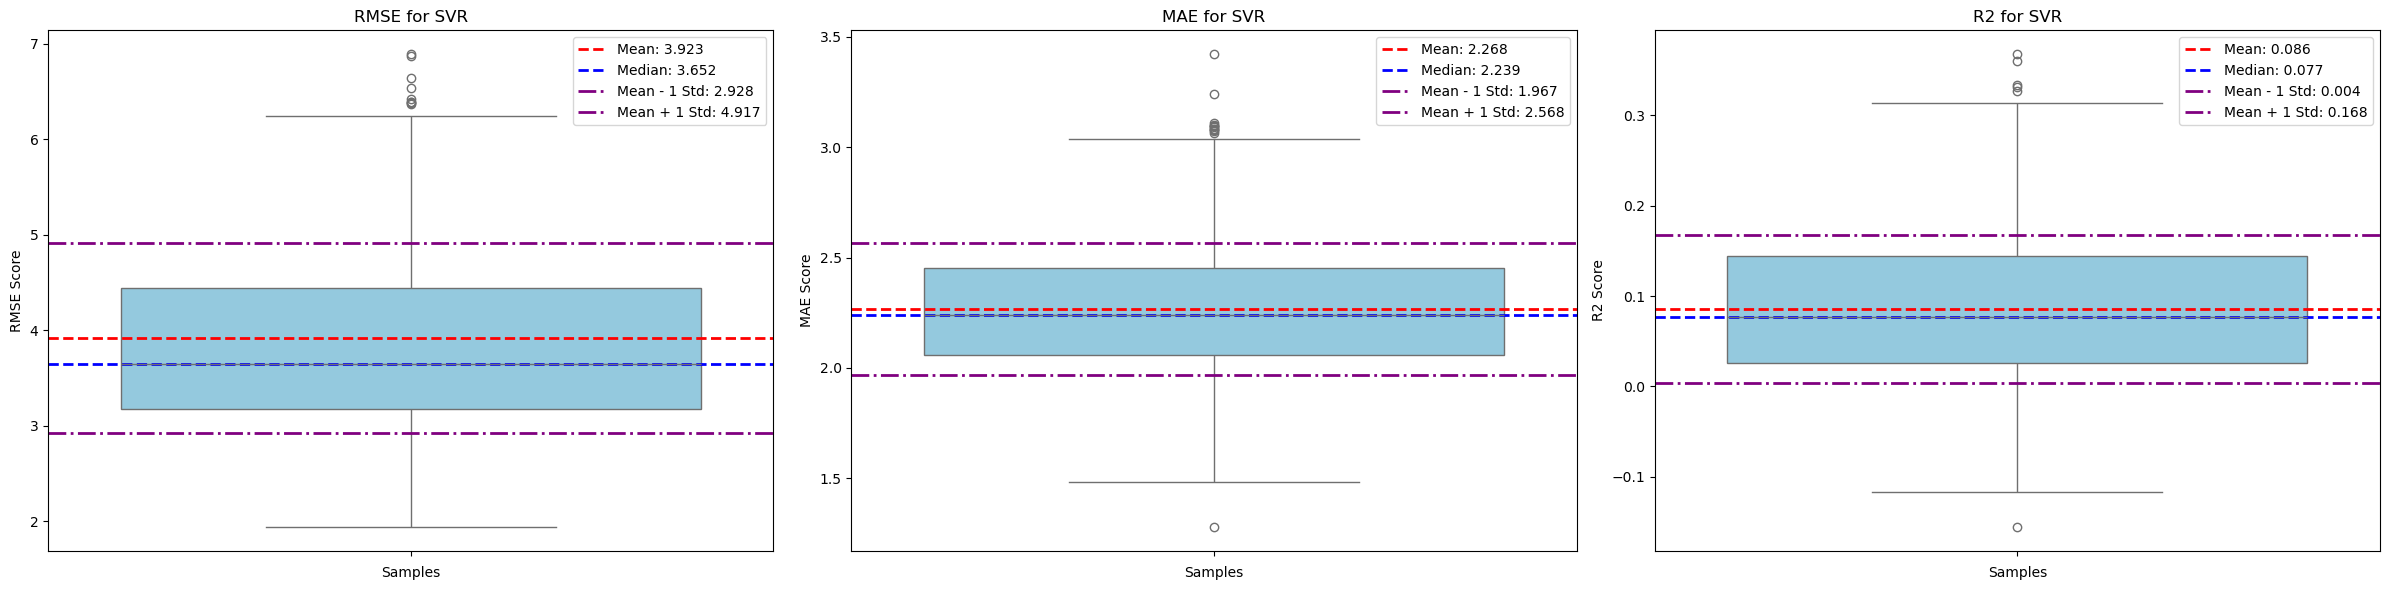

In [6]:
models = [ElasticNet(alpha=1.6174922915452128, l1_ratio=0.003659782920642262), BayesianRidge(alpha_1=4.710714054814993e-07, lambda_1=1.2415064644983772e-05, alpha_2=7.098980122317167e-07, lambda_2=9.98609837502576e-05), SVR(C=5.481042585645274, kernel='rbf', gamma='scale', epsilon=0.0300079986016957)]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=50))
    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=30))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=95))
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_optuna.pkl", save=True)
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])
    
    
